In [248]:
'''
Allstate is currently developing automated methods of predicting the cost, and hence severity, of claims.
In this recruitment challenge, Kagglers are invited to show off their creativity and flex their technical chops 
by creating an algorithm which accurately predicts claims severity. 
Aspiring competitors will demonstrate insight into better ways to predict claims severity for the chance to be part of Allstate’s efforts 
to ensure a worry-free customer experience.

Notes:
- Predictions of claims severity.
- This is regression problem.
'''
%reset

In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, Ridge, ElasticNet

from sklearn.metrics import mean_squared_error, explained_variance_score

import warnings
warnings.filterwarnings(action='once')

Using matplotlib backend: MacOSX


In [250]:
ID = 'id'
TARGET = 'loss'
COLUMNS_TO_DROP = [
    'id', 'cat3', 'cat7', 'cat8', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18',
    'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30',
    'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 
    'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55',
    'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67',
    'cat68', 'cat69', 'cat70', 'cat71', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat81',
    'cat84', 'cat85', 'cat87', 'cat88', 'cat89', 'cat90', 'cat96', 'cat102', 'cat109', 'cont12']

CROSS_VALIDATION = 20

In [288]:
def get_quantitative_and_qualitative_columns(df):
    quantitative = list(df._get_numeric_data().columns)
    quantitative = [col for col in quantitative if col not in ID + TARGET]
    qualitative = [col for col in list(df.columns) if col not in quantitative]
    qualitative = [col for col in qualitative if col not in ID + TARGET]
    return quantitative, qualitative

def get_train():
    # Transfrom target value - log transformation.
    train = pd.read_csv('train.csv')
    train[TARGET] = np.log1p(train[TARGET])
    return train

def get_test():
    return pd.read_csv('test.csv')

def transformation(df):
    df_transformed = df.copy()
    df_transformed.drop(COLUMNS_TO_DROP, inplace=True, axis=1)
    
    quantitative, qualitative = get_quantitative_and_qualitative_columns(df_transformed)
    df_transformed_one_hot_encoded = pd.get_dummies(df_transformed[qualitative], drop_first=True)
    df_transformed.drop(qualitative, axis=1, inplace=True)
    df_transformed = pd.concat([df_transformed, df_transformed_one_hot_encoded], axis=1) 
    
    return df_transformed

def drop_not_common_features(train, test):
    not_in_test = [col for col in list(test.columns) if col not in list(train.columns)]
    test.drop(not_in_test, axis=1, inplace=True)

    not_in_train = [col for col in list(train.columns) if col not in list(test.columns)]
    not_in_train.remove(TARGET)  # Keep TARGET feature.
    train.drop(not_in_train, axis=1, inplace=True)
    
    return train, test

def feature_selection(train, test):
    y = train[TARGET].copy()
    X = train.drop(TARGET, axis=1).copy()
    extra_trees_regressor = ExtraTreesRegressor()
    extra_trees_regressor.fit(X, y)
    select_from_model = SelectFromModel(extra_trees_regressor, prefit=True)
    columns_to_keep = select_from_model.get_support(indices=False)
    columns_to_drop = pd.DataFrame({
        'feature': list(X.columns),
        'to_keep': columns_to_keep,
    })
    columns_to_drop = list(columns_to_drop.loc[columns_to_drop['to_keep'] == False, 'feature'])

    train = train.drop(columns_to_drop, axis=1)
    test = test.drop(columns_to_drop, axis=1)
    return train, test

def train_model(estimator, param_grid, X_train, y_train, cv):
    model = GridSearchCV(estimator, param_grid, cv=cv)
    model.fit(X_train, y_train)
    return model

def predict(model, X_valid_test):
    prediction = model.predict(X_valid_test)
    prediction = np.exp(prediction)
    return pd.Series(prediction, index=X_valid.index)
    
def evaluate_model(y_true, prediction):
    r2 = explained_variance_score(y_true, prediction)
    mse = mean_squared_error(y_true, prediction)

    print('R2: {}'.format(r2))
    print('MSE: {}'.format(mse))
    print('\n')

    prediction_residuals = pd.DataFrame({
        'prediction': prediction,
        'residuals': y_true - prediction
    })
    sns.lmplot(x='prediction', y='residuals', data=prediction_residuals, fit_reg=False)

# Preparation

In [253]:
%%time
train = transformation(get_train())
test = transformation(get_test())
train, test = drop_not_common_features(train, test)

CPU times: user 6.45 s, sys: 1.41 s, total: 7.86 s
Wall time: 7.92 s


In [254]:
%%time
# I have more than 700 features at this point. Would be nice to reduce the number.
train, test = feature_selection(train, test)

CPU times: user 4min 3s, sys: 2.05 s, total: 4min 5s
Wall time: 4min 6s


# Modelling

In [255]:
# Preparing proper sets of data.
X_test = test.copy()

y = train[TARGET].copy()
X = train.drop(TARGET, axis=1).copy()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=123)

print('X_train shape: {}'.format(X_train.shape))
print('X_valid shape: {}'.format(X_valid.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (131821, 147)
X_valid shape: (56496, 147)
X_test shape: (125545, 147)


R2: 0.33465491095578204
MSE: 5623598.272736607


CPU times: user 3min 59s, sys: 48.7 s, total: 4min 48s
Wall time: 1min 44s


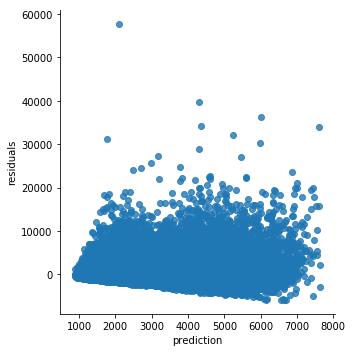

In [294]:
%%time
# Lasso.
lasso = Lasso()
param_grid = {
    'alpha': [0.01, 0.1, 1],
    'normalize': [False, True],
}
model = train_model(lasso, param_grid, X_train, y_train, CROSS_VALIDATION)
prediction = predict(model, X_valid)
evaluate_model(np.exp(y_valid), prediction)

In [295]:
%%time
# Ridge.
ridge = Ridge()
param_grid = {
    'alpha': [0.01, 0.1, 1],
    'normalize': [False, True],
}
model = train_model(ridge, param_grid, X_train, y_train, CROSS_VALIDATION)
prediction = predict(model, X_valid)
evaluate_model(np.exp(y_valid), prediction)

KeyboardInterrupt: 

In [296]:
%%time
# ElasticNet.
elastic_net = ElasticNet()
param_grid = {
    'alpha': [0.01, 0.1, 1,],
    'l1_ratio': [0.05, 0.5, 5],
    'normalize': [False, True],
}
model = train_model(elastic_net, param_grid, X_train, y_train, CROSS_VALIDATION)
prediction = predict(model, X_valid)
evaluate_model(np.exp(y_valid), prediction)

KeyboardInterrupt: 

# Data analysis

In [104]:
train = pd.read_csv('train.csv')
quantitative, qualitative = get_quantitative_and_qualitative_columns(train)

In [107]:
train.head()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cat116_P,cat116_Q,cat116_R,cat116_S,cat116_T,cat116_U,cat116_V,cat116_W,cat116_X,cat116_Y
0,1,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,...,0,0,0,0,0,0,0,0,0,0
1,2,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,...,0,0,0,0,0,0,0,0,0,0
2,5,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,...,0,0,0,0,0,0,0,0,0,0
3,10,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,...,0,0,0,0,0,0,0,0,0,0
4,11,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,...,0,0,0,0,0,0,0,0,0,0


In [24]:
test.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,4,A,B,A,A,A,A,A,A,B,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,6,A,B,A,B,A,A,A,A,B,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,9,A,B,A,B,B,A,B,A,B,...,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,12,A,A,A,A,B,A,A,A,A,...,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,15,B,A,A,A,A,B,A,A,A,...,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823


/Users/slechwar/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


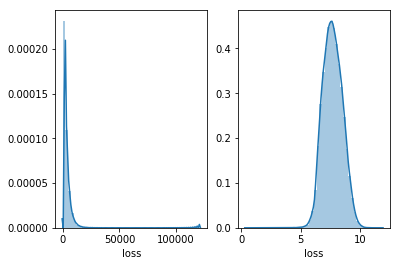

In [25]:
# Target variable.
plt.subplots()
plt.subplot(121)
sns.distplot(train[TARGET])
plt.subplot(122)
sns.distplot(np.log1p(train[TARGET]))

In [94]:
# Rarely changing qualitative features.
threshold = 0.8
def get_rarely_changing_qualitative_features(df, column):
    result = (df[column].value_counts() / df[column].shape[0]).sort_values(ascending=False).head(1)
    result = 1 if float(result) >= threshold else 0
    return (column, result)

rarely_changing_qualitative_features = []
for column in qualitative:
    tmp = get_rarely_changing_qualitative_features(train, column)
    rarely_changing_qualitative_features.append(tmp)
    
rarely_changing_qualitative_features = pd.DataFrame(rarely_changing_qualitative_features)
rarely_changing_qualitative_features.columns = ['column', 'is_rarely_changing']
columns_to_drop_qualitative = list(rarely_changing_qualitative_features.loc[rarely_changing_qualitative_features['is_rarely_changing'] == 1, 'column'])

In [85]:
%%time
# ANOVA or Kruskal-Wallis test
# some features may influance SalePrice more than others 
# compute one-way ANOVA or Kruskal-Wallis test to find out if average/median of more than two groups is statistically different
from scipy.stats import f_oneway, kruskal
quantitative, qualitative = get_quantitative_and_qualitative_columns(train)

# Calculate p-value.
# The null hypothesis is that two or more groups have the same population mean
def _test_for_one_feature(test_type, df, column, target):
    groups = list(df[column].unique())
    to_test = []
    for group in groups:
        tmp = df.loc[df[column] == group, target]
        to_test.append(list(tmp))

    if test_type == 'anova':
        return f_oneway(*to_test)[1] 
    elif test_type == 'kruskal':
        return kruskal(*to_test)[1] 
    else:
        raise Exception('Wrong test_type provided. Should be "anova" or "kruskal".')

result = []
for column in qualitative:
    tmp = _test_for_one_feature(test_type='kruskal', df=train, column=column, target=TARGET)
    result.append((column, tmp))
    
result = pd.DataFrame(anova)
result.columns = ['feature', 'p_value']

CPU times: user 16.9 s, sys: 228 ms, total: 17.1 s
Wall time: 17.1 s


In [88]:
result.sort_values(by='p_value', ascending=False).head(10)
# We do not have p_values > 0.5 so I will keep all features.

,feature,p_value
69,cat70,3.779210e-01
14,cat15,1.100828e-01
53,cat54,6.268841e-02
21,cat22,2.442265e-02
62,cat63,2.129854e-02
20,cat21,2.997992e-03
67,cat68,2.572093e-03
61,cat62,2.262315e-07
96,cat97,9.192235e-08
26,cat27,4.701858e-08


In [100]:
# Handle NULLs
# train.isna().sum().sort_values(ascending=False)
# We do not have NULLs

/Users/slechwar/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


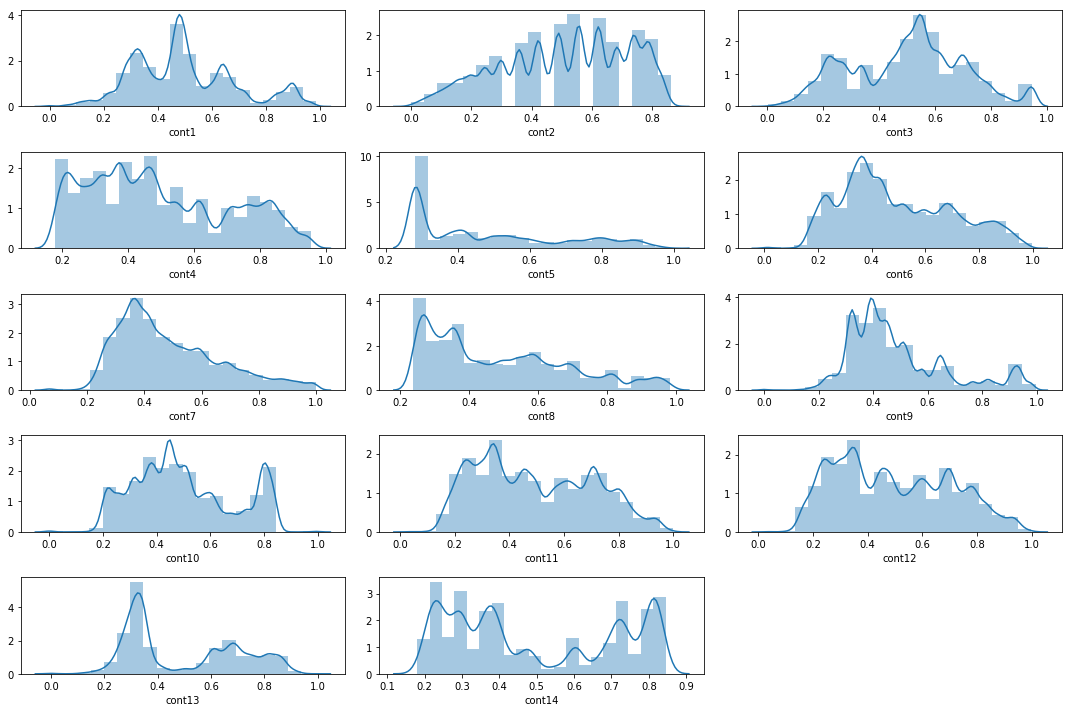

In [130]:
# Quantitative data analysis.
quantitative, qualitative = get_quantitative_and_qualitative_columns(train)
plt.figure(figsize=(15, 10))
for iter in range(len(quantitative)):
    plt.subplot(5, 3, iter + 1)
    sns.distplot(train[quantitative[iter]], bins=20)
    plt.tight_layout()
    
# We have many multimodal features. I will not transform them atm.

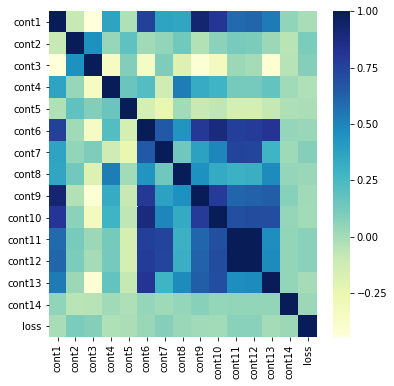

In [147]:
# Features correlation
quantitative, qualitative = get_quantitative_and_qualitative_columns(train)
cols_for_correlation = quantitative + [TARGET]
correlation = train[cols_for_correlation].corr()
plt.figure(figsize=(6,6))
sns.heatmap(correlation, cmap='YlGnBu')
# There's some diversity, let's work on that.
# Strategy: drop one from highly correlated feature pairs

In [169]:
correlated_features = []
for column in list(correlation.columns):
    tmp = (column, list(correlation[correlation[column] >= 0.95].index.values))
    correlated_features.append(tmp)
correlated_features
# To be removed: cont12

[('cont1', ['cont1']),
 ('cont2', ['cont2']),
 ('cont3', ['cont3']),
 ('cont4', ['cont4']),
 ('cont5', ['cont5']),
 ('cont6', ['cont6']),
 ('cont7', ['cont7']),
 ('cont8', ['cont8']),
 ('cont9', ['cont9']),
 ('cont10', ['cont10']),
 ('cont11', ['cont11', 'cont12']),
 ('cont12', ['cont11', 'cont12']),
 ('cont13', ['cont13']),
 ('cont14', ['cont14']),
 ('loss', ['loss'])]